<a href="https://colab.research.google.com/github/PrithaSarkar/Dissertation/blob/main/Pull_request_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GPU Availability**

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Installing and importing necessary packages.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import sklearn

Mounting drive and loading the datafile. Change the location as applicable.

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Dissertation UofG 2022/new_pullreq.csv")

In [4]:
columns = df.columns.to_list()
print(columns)

['id', 'project_id', 'github_id', 'pull_request_id', 'ownername', 'reponame', 'merged_or_not', 'lifetime_minutes', 'mergetime_minutes', 'num_commits', 'src_churn', 'test_churn', 'files_added', 'files_deleted', 'files_modified', 'files_changed', 'src_files', 'doc_files', 'other_files', 'num_commit_comments', 'num_issue_comments', 'num_comments', 'num_participants', 'sloc', 'team_size', 'perc_external_contribs', 'commits_on_files_touched', 'test_lines_per_kloc', 'test_cases_per_kloc', 'asserts_per_kloc', 'watchers', 'prev_pullreqs', 'requester_succ_rate', 'followers', 'churn_addition', 'churn_deletion', 'pr_comment_num', 'comment_num', 'perc_neg_emotion', 'perc_pos_emotion', 'perc_neu_emotion', 'part_num_issue', 'part_num_commit', 'part_num_pr', 'part_num_code', 'comment_conflict', 'hash_tag', 'at_tag', 'test_inclusion', 'description_length', 'bug_fix', 'ci_exists', 'ci_latency', 'ci_build_num', 'ci_test_passed', 'ci_failed_perc', 'ci_first_build_status', 'ci_last_build_status', 'languag

The "merged_or_not" metric states whether a pull-request was accepted or not. Let us check, how many of the 3 million pull-request was accepted and how many were rejected.

In [5]:
accepted = 0
rejected = 0
for ind in df.index:
  if df["merged_or_not"][ind]==1:
    accepted = accepted+1
  else:
    rejected = rejected+1

print("Accepted:", accepted)
print("Percentage:", (accepted/len(df))*100)
print("Rejected:", rejected)
print("Percentage:", (rejected/len(df))*100)

Accepted: 2710096
Percentage: 80.94823767591804
Rejected: 637841
Percentage: 19.051762324081963


There is a huge imbalance in the two classes. This needs to be kept in mind from this point onwards.

**Preparing data for small-scale experiment.**

The original dataset has 120 columns/metrics related to each pull-request. However, we will only focus on the metrics present in Table 1 of [this paper](https://dl.acm.org/doi/10.1145/3379597.3387489).

In [6]:
def flow_from_df(dataframe: pd.DataFrame, chunk_size: int = int(len(df)/2)):
  for start_row in range(0, dataframe.shape[0], chunk_size):
    end_row  = min(start_row + chunk_size, dataframe.shape[0])
    yield dataframe.iloc[start_row:end_row, :]

In [7]:
get_chunk = flow_from_df(df)
train_test = next(get_chunk)
train_test

,id,project_id,github_id,pull_request_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
0,1,13708387,1895,16946031,stylelint,stylelint,1,237,237.0,1,...,0,0,0,0,30.0,1,0.007948,0,237,0
1,2,100297899,353,51228565,Joaogarciadelima,checklistos,0,1410,NaN,1,...,0,2,0,0,597.0,0,0.830769,0,1410,0
2,3,93139005,404,42975776,binary-com,SmartCharts,1,4,4.0,1,...,0,0,0,0,2.0,0,0.314368,0,4,0
3,4,15059440,3434,34700062,letsencrypt,boulder,1,52,52.0,1,...,0,0,0,0,1.0,0,0.117332,0,52,0
4,5,29684214,486,34175163,PyCQA,astroid,1,2414,2414.0,1,...,0,0,0,0,2.0,0,0.010753,0,2414,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673963,1673964,8504763,1205,20816393,os-autoinst,openQA,1,77,77.0,1,...,1,2,0,0,6.0,1,0.119597,0,77,0
1673964,1673965,10789805,141,4184228,geopandas,geopandas,1,418,418.0,4,...,1,2,0,0,48.0,0,0.037736,0,418,0
1673965,1673966,26051663,5794,45711167,JMRI,JMRI,1,151,151.0,1,...,0,0,0,0,51.0,0,0.094772,0,151,0
1673966,1673967,4952323,91,2361445,spring-projects,spring-data-mongodb,0,122689,NaN,3,...,0,0,0,0,149.0,0,0.478788,0,122689,0


In [8]:
list_of_metrics = ['id','acc_commit_num', 'first_pr', 'core_member',
                  'contrib_gender', 'same_country', 'same_affiliation',
                  'social_strength', 'account_creation_days',
                  'first_response_time', 'contrib_country',
                  'prior_interaction', 'contrib_affiliation', 'perc_external_contribs',
                  'contrib_first_emo', 'contrib_follow_integrator',
                  'language', 'project_age', 'pushed_delta',
                  'pr_succ_rate', 'open_issue_num', 'open_pr_num', 'fork_num',
                  'churn_addition', 'bug_fix', 'test_inclusion',
                  'hash_tag', 'at_tag', 'part_num_issue', 'part_num_commit',
                  'part_num_pr', 'part_num_code','ci_exists', 'ci_latency',
                  'ci_test_passed', 'ci_failed_perc', 'churn_deletion',
                  'description_length', 'comment_conflict', 'pr_comment_num',
                  'part_num_code', 'ci_build_num', 'perc_inte_neg_emo', 'perc_inte_pos_emo',
                  'perc_inte_neu_emo','ci_first_build_status', 'ci_last_build_status',
                   'merged_or_not']

for metric in columns:
  if metric not in list_of_metrics:
    train_test.drop(metric, axis=1, inplace=True)

train_test

,id,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
0,1,1,0.089869,0,0,0,1,0,0,0,...,NaN,NaN,0.000000,0.0,1.000000,0,28,0.000000,NaN,NaN
1,2,0,0.014019,0,0,0,1,0,0,0,...,NaN,NaN,0.000000,0.0,0.000000,0,300,0.250000,NaN,NaN
2,3,1,0.256849,0,0,0,0,0,0,0,...,NaN,NaN,0.000000,0.0,0.000000,0,505,0.428571,1.0,NaN
3,4,1,0.014706,110,3,0,0,0,0,0,...,NaN,NaN,0.000000,0.0,0.000000,1,460,0.138889,NaN,NaN
4,5,1,0.173077,60,0,0,1,0,0,0,...,NaN,NaN,0.000000,1.0,0.000000,1,6,0.125000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673963,1673964,1,0.011392,4,0,0,3,0,0,0,...,suse,neutral,0.000000,1.0,0.000000,0,132,0.384615,NaN,1.0
1673964,1673965,1,0.018182,173,2,0,4,0,0,0,...,mapbox,neutral,0.333333,0.0,0.666667,0,36,0.400000,1.0,0.0
1673965,1673966,1,0.254067,1,0,0,0,0,0,0,...,acm,NaN,0.000000,0.0,0.000000,0,204,0.215686,1.0,1.0
1673966,1673967,0,0.150327,15,14,0,0,0,0,0,...,NaN,NaN,0.000000,0.0,0.000000,1,88,0.285714,NaN,NaN


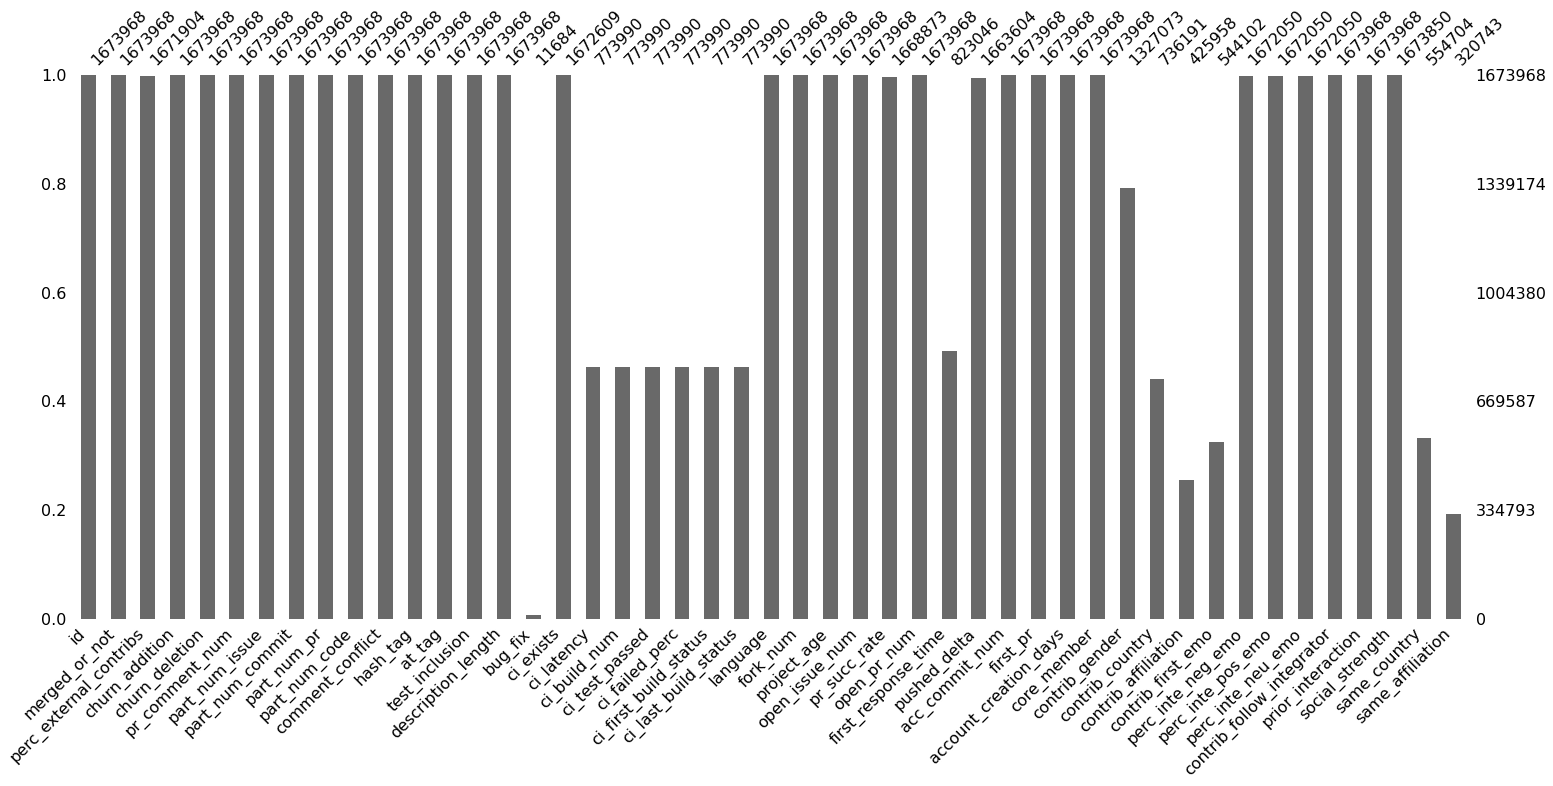

In [9]:
msno.bar(train_test)

Even though there are a couple of metrics which have high number of null values, decision to keep them for now has been taken. Feature selection will be done when XGBoost will be deployed on the data. Subsequently, the most important features will be observed and the rest of them will be dropped from the experiment.

Let us now see the percentage of accepted and rejected pull-request in this data chunk and see if the class imbalance remains the same or has worsened.

In [10]:
accepted = 0
rejected = 0
for ind in train_test.index:
  if train_test["merged_or_not"][ind]==1:
    accepted = accepted+1
  else:
    rejected = rejected+1

print("Accepted:", accepted)
print("Percentage:", (accepted/len(train_test))*100)
print("Rejected:", rejected)
print("Percentage:", (rejected/len(train_test))*100)

Accepted: 1355422
Percentage: 80.97060397809277
Rejected: 318546
Percentage: 19.029396021907232


Splitting the train_eval_test dataframe into separate training, evaluation and testing sets. 50% of the entire dataset will be used for training, 30% of the dataset will be used for evaluation/validation purposes and the remaining 20% will be used to run tests.

An important step before that would be to check the data types of every column since classification models would expect int, bool or float daat types. However, the dataset is diverse and annotation is required.

In [11]:
print(train_test.dtypes)

id                             int64
merged_or_not                  int64
perc_external_contribs       float64
churn_addition                 int64
churn_deletion                 int64
pr_comment_num                 int64
part_num_issue                 int64
part_num_commit                int64
part_num_pr                    int64
part_num_code                  int64
comment_conflict               int64
hash_tag                       int64
at_tag                         int64
test_inclusion                 int64
description_length             int64
bug_fix                      float64
ci_exists                    float64
ci_latency                   float64
ci_build_num                 float64
ci_test_passed               float64
ci_failed_perc               float64
ci_first_build_status         object
ci_last_build_status          object
language                      object
fork_num                       int64
project_age                    int64
open_issue_num                 int64
p

Metrics "ci_first_build_status", "ci_last_build_status", "language", "contrib_gender", contrib_country", "contrib_affiliation", "contrib_first_emo" have data type of object. This would cause trouble when deploying XGBoost. Annotation is needed in this case; manual or otherwise. Let's check the unique values present in each of these metrics.

In [12]:
object_metrics = ['ci_first_build_status', 'ci_last_build_status', 'language', 
                  'contrib_gender', 'contrib_country', 'contrib_affiliation', 'contrib_first_emo']

for metric in object_metrics:
  if metric == 'ci_first_build_status':
    ci_first_build_unique = train_test[metric].unique()
    print(metric,':', ci_first_build_unique, ', #',len(ci_first_build_unique))
  if metric == 'ci_last_build_status':
    ci_last_build_unique = train_test[metric].unique()
    print(metric,':', ci_last_build_unique, ', #',len(ci_last_build_unique))
  if metric == 'language':
    language_unique = train_test[metric].unique()
    print(metric,':', language_unique, ', #',len(language_unique))
  if metric == 'contrib_gender':
    cotrib_gender_unique = train_test[metric].unique()
    print(metric,':', cotrib_gender_unique, ', #',len(cotrib_gender_unique))
  if metric == 'contrib_country':
    cotrib_country_unique = train_test[metric].unique()
    print(metric,':', cotrib_country_unique, ', #',len(cotrib_country_unique))
  if metric == 'contrib_affiliation':
    cotrib_affiliation_unique = train_test[metric].unique()
    print(metric,':', cotrib_affiliation_unique, ', #',len(cotrib_affiliation_unique))
  if metric == 'contrib_first_emo':
    cotrib_first_emo_unique = train_test[metric].unique()
    print(metric,':', cotrib_first_emo_unique, ', #',len(cotrib_first_emo_unique))   

ci_first_build_status : ['success' 'failure' nan] , # 3
ci_last_build_status : ['success' 'failure' nan] , # 3
language : ['JavaScript' 'Python' 'Go' 'Scala' 'Java' 'Ruby'] , # 6
contrib_gender : [nan 'male' 'female'] , # 3
contrib_country : [nan 'malaysia' 'canada' 'united states' 'peru' 'portugal' 'brazil'
 'austria' 'united kingdom' 'hungary' 'south africa' 'nepal' 'nicaragua'
 'russia' 'turkey' 'italy' 'china' 'iran' 'spain' 'czech republic'
 'germany' 'japan' 'nigeria' 'new zealand' 'pakistan' 'philippines'
 'australia' 'sri lanka' 'ukraine' 'switzerland' 'singapore' 'france'
 'belgium' 'chile' 'india' 'poland' 'taiwan' 'bangladesh' 'finland'
 'costa rica' 'netherlands' 'lithuania' 'greece' 'ireland' 'south korea'
 'norway' 'denmark' 'argentina' 'venezuela' 'belarus'
 'northern mariana islands' 'vietnam' 'luxembourg' 'lebanon' 'uzbekistan'
 'sweden' 'bulgaria' 'uganda' 'slovenia' 'croatia' 'united arab emirates'
 'estonia' 'israel' 'panama' 'indonesia' 'latvia' 'mexico' 'romania'


[LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) from sklearn's preprocessing package was used to annotate these unique values. However, a separate DataFrame was created to preserve the original data as that would come handy later on while recommendations are done.

In [13]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

labelled_data = pd.DataFrame(columns = object_metrics)
for metric in object_metrics:
  labelled_data[metric] = train_test[metric]
for metric in object_metrics:
  train_test[metric] = le.fit_transform(train_test[metric])

In [14]:
labelled_data

,ci_first_build_status,ci_last_build_status,language,contrib_gender,contrib_country,contrib_affiliation,contrib_first_emo
0,success,success,JavaScript,NaN,NaN,NaN,NaN
1,failure,failure,Python,NaN,NaN,NaN,NaN
2,success,success,JavaScript,male,malaysia,NaN,NaN
3,success,success,Go,male,canada,NaN,NaN
4,success,success,Python,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1673963,success,success,JavaScript,male,czech republic,suse,neutral
1673964,success,failure,Python,male,united states,mapbox,neutral
1673965,NaN,NaN,Java,male,united states,acm,NaN
1673966,NaN,NaN,Java,male,NaN,NaN,NaN


In [15]:
train_test.language

0          2
1          3
2          2
3          0
4          3
          ..
1673963    2
1673964    3
1673965    1
1673966    1
1673967    2
Name: language, Length: 1673968, dtype: int64

In [21]:
for metric in object_metrics:
  globals()['dict_%s' % metric] = pd.Series(labelled_data[metric].values,index=train_test[metric]).to_dict()

In [26]:
dict_ci_first_build_status

{0: 'failure', 1: 'success', 2: nan}

In [28]:
dict_ci_last_build_status

{0: 'failure', 1: 'success', 2: nan}

In [29]:
dict_language

{0: 'Go', 1: 'Java', 2: 'JavaScript', 3: 'Python', 4: 'Ruby', 5: 'Scala'}

In [30]:
dict_contrib_gender

{0: 'female', 1: 'male', 2: nan}

In [31]:
dict_contrib_country

{0: 'afghanistan',
 1: 'albania',
 2: 'algeria',
 3: 'andorra',
 4: 'angola',
 5: 'anguilla',
 6: 'antarctica',
 7: 'argentina',
 8: 'armenia',
 9: 'australia',
 10: 'austria',
 11: 'azerbaijan',
 12: 'bahrain',
 13: 'bangladesh',
 14: 'barbados',
 15: 'belarus',
 16: 'belgium',
 17: 'benin',
 18: 'bermuda',
 19: 'bhutan',
 20: 'bolivia',
 21: 'bosnia and herzegovina',
 22: 'brazil',
 23: 'brunei',
 24: 'bulgaria',
 25: 'cambodia',
 26: 'cameroon',
 27: 'canada',
 28: 'cayman islands',
 29: 'chile',
 30: 'china',
 31: 'cocos islands',
 32: 'colombia',
 33: 'congo',
 34: 'costa rica',
 35: "cote d'ivoire",
 36: 'croatia',
 37: 'cuba',
 38: 'cyprus',
 39: 'czech republic',
 40: 'denmark',
 41: 'dominican republic',
 42: 'ecuador',
 43: 'egypt',
 44: 'el salvador',
 45: 'equatorial guinea',
 46: 'estonia',
 47: 'ethiopia',
 48: 'faroe islands',
 49: 'fiji',
 50: 'finland',
 51: 'france',
 52: 'french polynesia',
 53: 'georgia',
 54: 'germany',
 55: 'ghana',
 56: 'gibraltar',
 57: 'greece'

In [32]:
dict_contrib_affiliation

{1202: nan,
 815: 'sas',
 775: 'red hat',
 46: 'apache',
 719: 'pentaho',
 232: 'databricks',
 918: 'tableau',
 515: 'kitware',
 618: 'mulesoft',
 440: 'ibm',
 314: 'facebook',
 1183: 'zalando',
 407: 'hazelcast',
 599: 'microsoft',
 570: 'massachusetts institute of technology',
 805: 'salesforce',
 445: 'igalia',
 59: 'arm',
 960: 'thoughtworks',
 121: 'bosch software innovations gmbh',
 686: 'odoo',
 1070: 'university of michigan-ann arbor',
 617: 'mozilla',
 282: 'eleme',
 592: 'mesosphere',
 741: 'princeton university',
 76: 'automattic',
 713: 'paypal',
 384: 'google',
 893: 'stanford university',
 279: 'elastic',
 1019: 'university college london',
 335: 'forter',
 744: 'proofpoint',
 433: 'hubspot',
 924: 'target',
 233: 'datadog',
 393: 'gridgain',
 874: 'sonarsource',
 265: 'duckduckgo',
 787: 'ringcentral',
 184: 'code',
 1029: 'university of california, berkeley',
 371: 'github',
 425: 'hortonworks',
 1132: 'voltdb',
 716: 'peking university',
 428: 'hpe',
 247: 'devexpress'

In [33]:
dict_contrib_first_emo

{0: 'negative', 1: 'neutral', 2: 'positive', 3: nan}

The train_test dataframe is divided into two. One will be used to train the model while the other will be used for testing. The training sample will contain 60% of the rows present in the original train_test dataframe while the testing sample will contain the remaining 40%.

Code in the next 2 cells were taken from [here](https://stackoverflow.com/a/57198258).

In [34]:
def flow_from_df(dataframe: pd.DataFrame, chunk_size: int = int(len(train_test)*0.6)):
  for start_row in range(0, dataframe.shape[0], chunk_size):
    end_row  = min(start_row + chunk_size, dataframe.shape[0])
    yield dataframe.iloc[start_row:end_row, :]

In [35]:
get_chunk = flow_from_df(train_test)
train = next(get_chunk)

In [36]:
test = train_test.iloc[(train.index[-1]+1):train_test.index[-1], :]

In [37]:
len(train), len(test)

(1004380, 669587)

In [38]:
train.head(3)

,id,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
0,1,1,0.089869,0,0,0,1,0,0,0,...,1202,3,0.0,0.0,1.0,0,28,0.000000,NaN,NaN
1,2,0,0.014019,0,0,0,1,0,0,0,...,1202,3,0.0,0.0,0.0,0,300,0.250000,NaN,NaN
2,3,1,0.256849,0,0,0,0,0,0,0,...,1202,3,0.0,0.0,0.0,0,505,0.428571,1.0,NaN


In [39]:
test.head(3)

,id,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
1004380,1004381,1,0.000000,0,0,0,4,0,0,0,...,904,1,0.0,0.0,0.0,0,523,0.714286,1.0,1.0
1004381,1004382,1,0.032621,0,0,0,0,0,0,0,...,1202,3,0.0,0.0,0.0,0,13,0.000000,NaN,NaN
1004382,1004383,1,0.042122,2450,249,0,2,0,0,0,...,1202,3,0.0,0.0,0.0,0,31,0.266667,NaN,NaN


# ***XGBoost***

Run the following cell to install XGBoost. Skip otherwise.

In [ ]:
#!pip3 install xgboost

In [40]:
from xgboost import XGBClassifier as xgb
from xgboost import plot_importance
import xgboost as xgb
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

Hyperparameter Tuning of XGBoost.

The next 3 cells contains code from the Kaggle notebook "[A Guide on XGBoost hyperparameters tuning](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook)"



In [44]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0}

def objective(space):
    clf=xgb.XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(train.iloc[:, 2:], train["merged_or_not"]), (test.iloc[:, 2:], test["merged_or_not"])]
    
    clf.fit(train.iloc[:, 2:], train["merged_or_not"],
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(test.iloc[:, 2:])
    accuracy = accuracy_score(test["merged_or_not"], pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [45]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.810451815820797
SCORE:
0.8105936943220223
SCORE:
0.8104697373156886
SCORE:
0.8104786980631344
SCORE:
0.8105892139482995
SCORE:
0.8104607765682428
SCORE:
0.8104622700261505
SCORE:
0.8104592831103352
SCORE:
0.810451815820797
SCORE:
0.8104548027366123
SCORE:
0.8104622700261505
SCORE:
0.8105473971268857
SCORE:
0.8105324625478093
SCORE:
0.8104533092787046
SCORE:
0.8105473971268857
SCORE:
0.8104996064738413
SCORE:
0.8105877204903918
SCORE:
0.8104757111473192
SCORE:
0.8105025933896566
SCORE:
0.8104548027366123
SCORE:
0.8105712924534079
SCORE:
0.8105264887161788
SCORE:
0.8105070737633795
SCORE:
0.8105697989955002
SCORE:
0.8105309690899016
SCORE:
0.810578759742946
SCORE:
0.8105100606791947
SCORE:
0.8105055803054719
SCORE:
0.8105488905847933
SCORE:
0.8105220083424559
SCORE:
0.8105414232952551
SCORE:
0.8104592831103352
SCORE:
0.8105055803054719
SCORE:
0.8104727242315038
SCORE:
0.8105369429215322
SCORE:
0.8104816849789497
SCORE:
0.810550384042701
SCORE:
0.8104816849789497
SCORE:
0.8104607

In [46]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.6181684614170972, 'gamma': 4.08581721001597, 'max_depth': 13.0, 'min_child_weight': 4.0, 'reg_alpha': 40.0, 'reg_lambda': 0.15452176042374727}


In [41]:
X = train.iloc[:, 2:]
y = train["merged_or_not"]

In [42]:
model = XGBClassifier()

In [43]:
print("Computation Time")
start=datetime.now()

model.fit(X,y)

print(datetime.now()-start)

Computation Time
0:02:42.284250


It is time to test the model out.

K-fold cross validation on XGBoost model. Setting some parameter values based off of educated guess.

In [ ]:
'''
from xgboost import cv

train_xgb = xgb.DMatrix(X, y)
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=train_xgb, params=params, nfold=3,
            num_boost_round=50, early_stopping_rounds=10, 
            metrics="auc", as_pandas=True, seed=123)
'''

'\nfrom xgboost import cv\n\ntrain_xgb = xgb.DMatrix(X, y)\nparams = {"objective":"binary:logistic",\'colsample_bytree\': 0.3,\'learning_rate\': 0.1,\n                \'max_depth\': 5, \'alpha\': 10}\n\nxgb_cv = cv(dtrain=train_xgb, params=params, nfold=3,\n            num_boost_round=50, early_stopping_rounds=10, \n            metrics="auc", as_pandas=True, seed=123)\n'

In [ ]:
#xgb_cv.head()

In [ ]:
y_pred = model.predict(test.iloc[:, 2:])
print(y_pred)

[1 1 1 ... 1 1 1]


In [ ]:
results = (test['merged_or_not'] == y_pred)
accuracy = results.sum() / results.size
print(accuracy)

0.8453240579640883


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def evaluation_summary(description, true_labels, predictions, target_classes):
  print("Evaluation for: " + description)
  target_names = target_classes
  report = classification_report(true_labels, predictions,  digits=3, zero_division=0, target_names=target_names)
  cm = confusion_matrix(true_labels, predictions)
  plt.figure(figsize=(5,5))
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax)
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title("Confusion Matrix")
  ax.xaxis.set_ticklabels(target_names) 
  ax.yaxis.set_ticklabels(target_names)
  return report

Evaluation for: Baseline Model
              precision    recall  f1-score   support

    Rejected      0.744     0.281     0.408    126934
    Accepted      0.853     0.977     0.911    542653

    accuracy                          0.845    669587
   macro avg      0.798     0.629     0.659    669587
weighted avg      0.832     0.845     0.816    669587



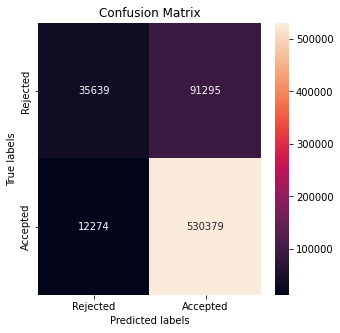

In [ ]:
target_classes = ['Rejected', 'Accepted']
print(evaluation_summary("Baseline Model", test["merged_or_not"], y_pred , target_classes))

ROC-AUC curve code taken from [here](https://www.kaggle.com/code/beletecheneke/xgboost-with-roc-curve-notebook-auprc-93) 

In [ ]:
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
def roc_auc_curve(test_results, y_pred):
  fpr, tpr, _ = roc_curve(test_results.values, y_pred)
  roc_auc = auc(fpr, tpr)
  #xgb.plot_importance(gbm)
  #plt.show()
  plt.figure(figsize=(5,5))
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([-0.02, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

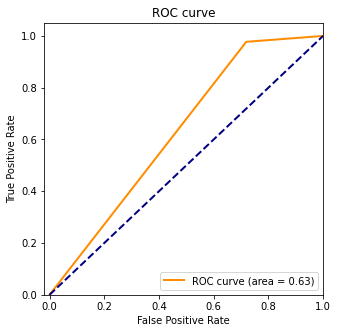

In [ ]:
roc_auc_curve(test["merged_or_not"], y_pred)

### **Feature Selection with XGBoost and SHAP**

Study [this](https://notebook.community/minesh1291/MachineLearning/xgboost/feature_importance_v1) to understand how feature importance is decided in the following graph.

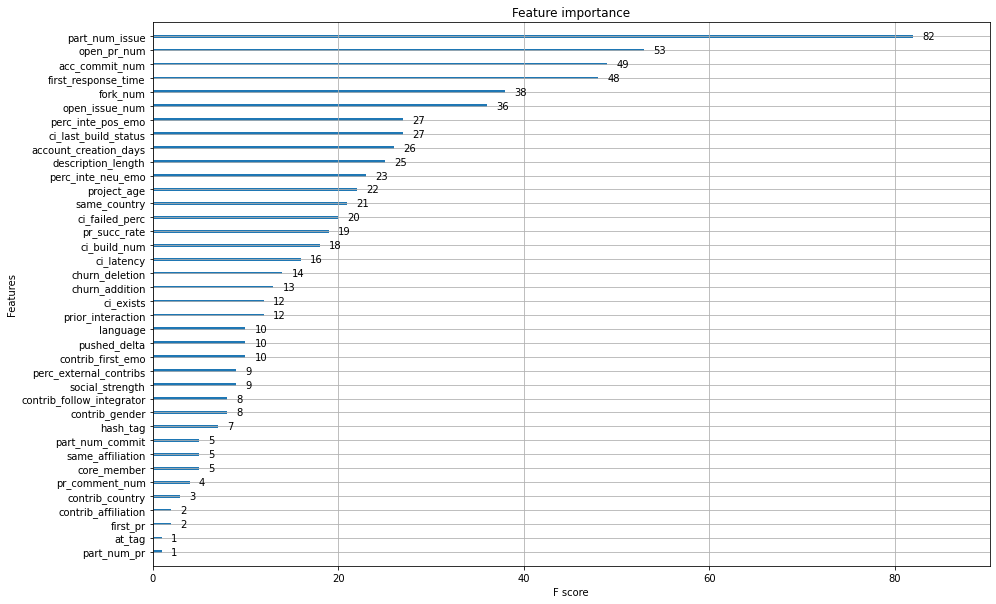

In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
plot_importance(model)
plt.show()

In [ ]:
#!pip3 install shap

In [ ]:
#import shap

In [ ]:
'''
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test)

shap.initjs()
shap.summary_plot(shap_values, test)
'''

'\nexplainer = shap.TreeExplainer(model)\nshap_values = explainer.shap_values(test)\n\nshap.initjs()\nshap.summary_plot(shap_values, test)\n'

Understanding the Shapley Value [here](https://christophm.github.io/interpretable-ml-book/shapley.html). [More](https://arxiv.org/pdf/2102.10936.pdf) things about Shapley.

Get rid of features one by one!

Interpreting the SHAP plot:
1. The y-axis indicates importance of the metrics with the top-most one being the most important one and the bottom one being the least important metric.
2. The x-axis is the SHAP values, indiacting the change in log-odds.
3. Gradient color indicates the original value for that variable. 
4. Each point represents the row from the original dataset.

[Reference] [link text](https://blog.datascienceheroes.com/how-to-interpret-shap-values-in-r/)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [ ]:
sorted_idx = np.argsort(model.feature_importances_)[::-1]
print(sorted_idx)
for index in sorted_idx:
  print([X.columns[index], model.feature_importances_[index]])

[36 32 41 29 42 18  4 20 27 31 26 24 25 15 14 22 23  1 34 33 12 38 16 43
 28  3  9 21  2  5 30 40  6 39  0 44 10 35  8  7 11 13 17 19 37]
['contrib_first_emo', 0.10956657]
['core_member', 0.103117965]
['prior_interaction', 0.07892003]
['acc_commit_num', 0.06839227]
['social_strength', 0.064916484]
['ci_failed_perc', 0.052375916]
['part_num_issue', 0.040689394]
['ci_last_build_status', 0.039726775]
['first_response_time', 0.0361695]
['account_creation_days', 0.03162656]
['open_pr_num', 0.028820295]
['open_issue_num', 0.02873026]
['pr_succ_rate', 0.026845938]
['ci_latency', 0.02636137]
['ci_exists', 0.024105432]
['fork_num', 0.022885673]
['project_age', 0.020077327]
['churn_addition', 0.016750911]
['contrib_country', 0.016352264]
['contrib_gender', 0.01584987]
['description_length', 0.014709954]
['perc_inte_pos_emo', 0.013268841]
['ci_build_num', 0.012396535]
['same_country', 0.011858753]
['pushed_delta', 0.011754432]
['pr_comment_num', 0.00984267]
['hash_tag', 0.008755989]
['language', 

Average for determining threshold.

In [ ]:
sum = 0.0
for value in model.feature_importances_:
  sum = sum+value

threshold_1 = sum/len(model.feature_importances_)
print(threshold_1)

0.022222221404727963


In [ ]:
imp_features_1 = []
for index in sorted_idx:
  if model.feature_importances_[index]>=threshold_1:
    imp_features_1.append(X.columns[index])

print(imp_features_1)
print(len(imp_features_1))

['contrib_first_emo', 'core_member', 'prior_interaction', 'acc_commit_num', 'social_strength', 'ci_failed_perc', 'part_num_issue', 'ci_last_build_status', 'first_response_time', 'account_creation_days', 'open_pr_num', 'open_issue_num', 'pr_succ_rate', 'ci_latency', 'ci_exists', 'fork_num']
16


In [ ]:
X_new_1 = pd.DataFrame(columns = imp_features_1)
for feature in imp_features_1:
  X_new_1[feature] = train[feature]

model_new = XGBClassifier()

print("Computation Time")
start=datetime.now()

model_new.fit(X_new_1, y)

print(datetime.now()-start)

test_new_1 = pd.DataFrame(columns = imp_features_1)
for feature in imp_features_1:
  test_new_1[feature] = test[feature]

y_pred_new_1 = model_new.predict(test_new_1)

Computation Time
0:01:20.896454


In [ ]:
results_new_1 = (test["merged_or_not"] == y_pred_new_1)
accuracy_new_1 = results_new_1.sum() / results_new_1.size
print(accuracy_new_1)

0.8444922019095353


Evaluation for: New Model with better performing features
              precision    recall  f1-score   support

    Rejected      0.734     0.282     0.407    126934
    Accepted      0.853     0.976     0.911    542653

    accuracy                          0.844    669587
   macro avg      0.794     0.629     0.659    669587
weighted avg      0.831     0.844     0.815    669587



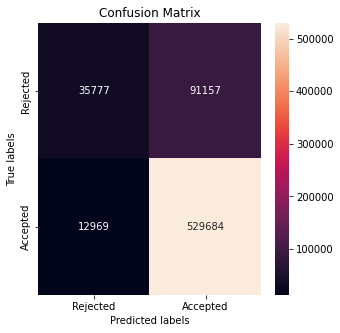

In [ ]:
print(evaluation_summary("New Model with better performing features", test["merged_or_not"], y_pred_new_1 , target_classes))

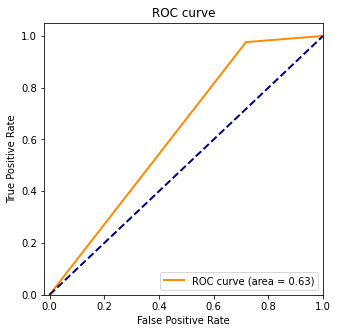

In [ ]:
roc_auc_curve(test["merged_or_not"], y_pred_new_1)

Read [this](https://ai.stanford.edu/blog/removing-spuriousfeature/).
[Deciding the threshold for feature importance.](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00472-4)

In [ ]:
'''
explainer_new_1 = shap.TreeExplainer(model_new)
shap_values_new_1 = explainer_new_1.shap_values(test_new_1)

shap.initjs()
shap.summary_plot(shap_values_new_1, test_new_1)
'''

'\nexplainer_new_1 = shap.TreeExplainer(model_new)\nshap_values_new_1 = explainer_new_1.shap_values(test_new_1)\n\nshap.initjs()\nshap.summary_plot(shap_values_new_1, test_new_1)\n'

Standard Deviation for determining threshold.

In [ ]:
threshold_2 = np.std(model.feature_importances_)

imp_features_2 = []
for index in sorted_idx:
  if model.feature_importances_[index]>=threshold_2:
    feature_to_consider_1 = X.columns[index]
    imp_features_2.append(feature_to_consider_1)

print(imp_features_2)
print(len(imp_features_2))

['contrib_first_emo', 'core_member', 'prior_interaction', 'acc_commit_num', 'social_strength', 'ci_failed_perc', 'part_num_issue', 'ci_last_build_status', 'first_response_time', 'account_creation_days', 'open_pr_num', 'open_issue_num', 'pr_succ_rate', 'ci_latency']
14


In [ ]:
X_new_2 = pd.DataFrame(columns = imp_features_2)
for feature in imp_features_2:
  X_new_2[feature] = train[feature]

print("Computation Time")
start=datetime.now()

model_new.fit(X_new_2, y)

print(datetime.now()-start)

test_new_2 = pd.DataFrame(columns = imp_features_2)
for feature in imp_features_2:
  test_new_2[feature] = test[feature]

y_pred_new_2 = model_new.predict(test_new_2)

Computation Time
0:01:15.124644


In [ ]:
results_new_2 = (test["merged_or_not"] == y_pred_new_2)
accuracy_new_2 = results_new_2.sum() / results_new_2.size
print(accuracy_new_2)

0.8431988673615228


Evaluation for: New Model with better performing features
              precision    recall  f1-score   support

    Rejected      0.727     0.277     0.401    126934
    Accepted      0.852     0.976     0.910    542653

    accuracy                          0.843    669587
   macro avg      0.789     0.626     0.656    669587
weighted avg      0.828     0.843     0.813    669587



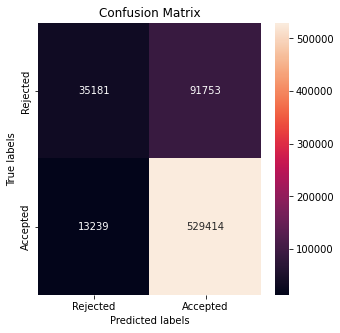

In [ ]:
print(evaluation_summary("New Model with better performing features", test["merged_or_not"], y_pred_new_2 , target_classes))

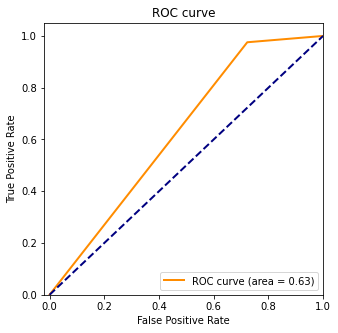

In [ ]:
roc_auc_curve(test["merged_or_not"], y_pred_new_2)

In [ ]:
'''
explainer_new_2 = shap.TreeExplainer(model_new)
shap_values_new_2 = explainer_new_2.shap_values(test_new_2)

shap.initjs()
shap.summary_plot(shap_values_new_2, test_new_2)
'''

'\nexplainer_new_2 = shap.TreeExplainer(model_new)\nshap_values_new_2 = explainer_new_2.shap_values(test_new_2)\n\nshap.initjs()\nshap.summary_plot(shap_values_new_2, test_new_2)\n'

Derivatives of feature importance values where dy = the feature importance value itself and dx = the mean of all the feature importance values. Determining the average of the dydx values for threshold.

In [ ]:
from numpy import diff

dx = threshold_1
features_dydx = diff(model.feature_importances_)/dx
print(features_dydx)

sum = 0.0
for value in features_dydx:
  sum = sum+value
threshold_3 = sum/len(features_dydx)
print(threshold_3)

imp_features_3 = []
for index in sorted_idx-1:
  for val in features_dydx:
    if val > threshold_3:
      feature_to_consider_2 = X.columns[index]
  imp_features_3.append(feature_to_consider_2)

print(imp_features_3)
print(len(imp_features_3))

[ 0.48061898 -0.38096985  0.07009895  1.3881027  -1.5039891  -0.03443496
 -0.29259875  0.          0.39401954 -0.28601605 -0.10800352  0.66194797
 -0.66194797  1.0847445   0.10151726 -0.6284176  -0.5578441   2.3569164
 -2.3569164   1.787705   -1.404324    0.6464745  -0.12637556  0.389382
 -0.08479452  0.08884608  0.33071423 -1.0986781   2.548703   -2.771058
  1.116601    3.2171135  -3.9270647   0.02260775 -0.628635    4.823279
 -4.9304957   0.5970979  -0.3150751   0.01720082  3.252178   -0.63015956
 -2.387598   -0.35477203]
-0.002143183088099415
['contrib_affiliation', 'account_creation_days', 'contrib_follow_integrator', 'pushed_delta', 'prior_interaction', 'ci_test_passed', 'pr_comment_num', 'ci_first_build_status', 'open_pr_num', 'first_pr', 'pr_succ_rate', 'project_age', 'open_issue_num', 'ci_exists', 'bug_fix', 'language', 'fork_num', 'perc_external_contribs', 'contrib_gender', 'core_member', 'test_inclusion', 'perc_inte_neg_emo', 'ci_latency', 'social_strength', 'first_response_t

In [ ]:
X_new_3 = pd.DataFrame(columns = imp_features_3)
for feature in imp_features_3:
  X_new_3[feature] = train[feature]

print("Computation Time")
start=datetime.now()

model_new.fit(X_new_3, y)

print(datetime.now()-start)

test_new_3 = pd.DataFrame(columns = imp_features_3)
for feature in imp_features_3:
  test_new_3[feature] = test[feature]

y_pred_new_3 = model_new.predict(test_new_3)

Computation Time
0:02:46.954308


In [ ]:
results_new_3 = (test["merged_or_not"] == y_pred_new_3)
accuracy_new_3 = results_new_3.sum() / results_new_3.size
print(accuracy_new_3)

0.8453240579640883


Evaluation for: New Model with better performing features
              precision    recall  f1-score   support

    Rejected      0.744     0.281     0.408    126934
    Accepted      0.853     0.977     0.911    542653

    accuracy                          0.845    669587
   macro avg      0.798     0.629     0.659    669587
weighted avg      0.832     0.845     0.816    669587



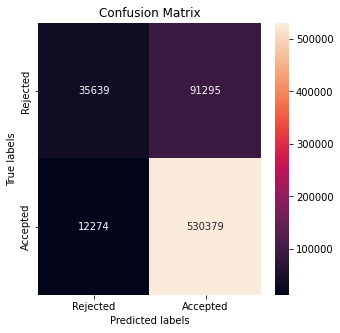

In [ ]:
print(evaluation_summary("New Model with better performing features", test["merged_or_not"], y_pred_new_3 , target_classes))

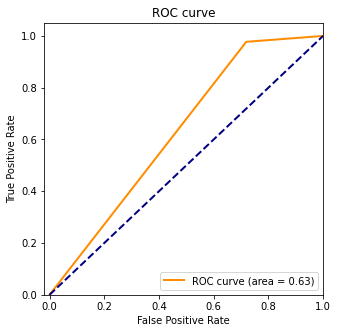

In [ ]:
roc_auc_curve(test["merged_or_not"], y_pred_new_3)

In [ ]:
'''
explainer_new_3 = shap.TreeExplainer(model_new)
shap_values_new_3 = explainer_new_3.shap_values(test_new_3)

shap.initjs()
shap.summary_plot(shap_values_new_3, test_new_3)
'''

'\nexplainer_new_3 = shap.TreeExplainer(model_new)\nshap_values_new_3 = explainer_new_3.shap_values(test_new_3)\n\nshap.initjs()\nshap.summary_plot(shap_values_new_3, test_new_3)\n'

Feature Selection with information gain and entropy.
[Here](https://www.kaggle.com/code/ma7555/decision-trees-information-gain-from-scratch), [here](https://https://www.sciencedirect.com/science/article/pii/S0957417420302001).

Information gain and entropy for feature selection.

In [ ]:
'''
import math
from collections import Counter

feature_gain = pd.DataFrame(columns = ["feature", "gain"])

def entropy(labels):
    entropy=0
    label_counts = Counter(labels)
    for label in label_counts:
        prob_of_label = label_counts[label] / len(labels)
        entropy -= prob_of_label * math.log2(prob_of_label)
    return entropy

def information_gain(starting_labels, split_labels):
    info_gain = entropy(starting_labels)
    for branched_subset in split_labels:
        info_gain -= len(branched_subset) * entropy(branched_subset) / len(starting_labels)
    return info_gain

def split(dataset, column):
    split_data = []
    col_vals = dataset[column].unique()
    for col_val in col_vals:
        split_data.append(dataset[dataset[column] == col_val])
    return(split_data)

def find_best_split(dataset):
  global feature_gain 
  feature_gain = pd.DataFrame(columns=['feature', 'gain'])
  best_gain = 0
  best_feature = 0
  features = list(dataset.columns)
  features.remove('merged_or_not')
  for feature in features:
    split_data = split(dataset, feature)
    split_labels = [dataframe['merged_or_not'] for dataframe in split_data]
    gain = information_gain(dataset['merged_or_not'], split_labels)
    new_row = {'feature': feature, 'gain': gain}
    feature_gain = feature_gain.append(new_row, ignore_index = True)
    if gain>best_gain:
      best_gain = gain
      best_feature = feature
  return best_feature, best_gain

new_data = split(train, find_best_split(train)[0])
'''

'\nimport math\nfrom collections import Counter\n\nfeature_gain = pd.DataFrame(columns = ["feature", "gain"])\n\ndef entropy(labels):\n    entropy=0\n    label_counts = Counter(labels)\n    for label in label_counts:\n        prob_of_label = label_counts[label] / len(labels)\n        entropy -= prob_of_label * math.log2(prob_of_label)\n    return entropy\n\ndef information_gain(starting_labels, split_labels):\n    info_gain = entropy(starting_labels)\n    for branched_subset in split_labels:\n        info_gain -= len(branched_subset) * entropy(branched_subset) / len(starting_labels)\n    return info_gain\n\ndef split(dataset, column):\n    split_data = []\n    col_vals = dataset[column].unique()\n    for col_val in col_vals:\n        split_data.append(dataset[dataset[column] == col_val])\n    return(split_data)\n\ndef find_best_split(dataset):\n  global feature_gain \n  feature_gain = pd.DataFrame(columns=[\'feature\', \'gain\'])\n  best_gain = 0\n  best_feature = 0\n  features = list(

In [ ]:
'''
feature_gain.head(5)
'''

'\nfeature_gain.head(5)\n'

In [ ]:
'''
feature_gain['top_most']=np.where(feature_gain['gain'].cumsum()<=feature_gain['gain'].sum() * 0.2,0,1)
feature_gain.sort_index(inplace=True)

feature_gain
'''

"\nfeature_gain['top_most']=np.where(feature_gain['gain'].cumsum()<=feature_gain['gain'].sum() * 0.2,0,1)\nfeature_gain.sort_index(inplace=True)\n\nfeature_gain\n"

In [ ]:
'''
sum = 0.0
for rows in feature_gain.itertuples():
  sum = sum+rows.gain

threshold_4 = sum/len(feature_gain)
print(threshold_4)
'''

'\nsum = 0.0\nfor rows in feature_gain.itertuples():\n  sum = sum+rows.gain\n\nthreshold_4 = sum/len(feature_gain)\nprint(threshold_4)\n'

In [ ]:
'''
imp_features_4 = []
for rows in feature_gain.itertuples():
  if rows.gain>=threshold_4:
    imp_features_4.append(rows.feature)

print(imp_features_4)
print(len(imp_features_4))
'''

'\nimp_features_4 = []\nfor rows in feature_gain.itertuples():\n  if rows.gain>=threshold_4:\n    imp_features_4.append(rows.feature)\n\nprint(imp_features_4)\nprint(len(imp_features_4))\n'

In [ ]:
'''
X_new_4 = pd.DataFrame(columns = imp_features_4)
for feature in imp_features_4:
  X_new_4[feature] = train[feature]

print("Computation Time")
start=datetime.now()

model_new.fit(X_new_4, y)

print(datetime.now()-start)

test_new_4 = pd.DataFrame(columns = imp_features_4)
for feature in imp_features_4:
  test_new_4[feature] = test[feature]

y_pred_new_4 = model_new.predict(test_new_4)
'''

'\nX_new_4 = pd.DataFrame(columns = imp_features_4)\nfor feature in imp_features_4:\n  X_new_4[feature] = train[feature]\n\nprint("Computation Time")\nstart=datetime.now()\n\nmodel_new.fit(X_new_4, y)\n\nprint(datetime.now()-start)\n\ntest_new_4 = pd.DataFrame(columns = imp_features_4)\nfor feature in imp_features_4:\n  test_new_4[feature] = test[feature]\n\ny_pred_new_4 = model_new.predict(test_new_4)\n'

In [ ]:
'''
results_new_4 = (test["merged_or_not"] == y_pred_new_4)
accuracy_new_4 = results_new_4.sum() / results_new_4.size
print(accuracy_new_4)
'''

'\nresults_new_4 = (test["merged_or_not"] == y_pred_new_4)\naccuracy_new_4 = results_new_4.sum() / results_new_4.size\nprint(accuracy_new_4)\n'

In [ ]:
'''
print(evaluation_summary("New Model with better performing features", test["merged_or_not"], y_pred_new_4, target_classes))
'''

'\nprint(evaluation_summary("New Model with better performing features", test["merged_or_not"], y_pred_new_4, target_classes))\n'

In [ ]:
'''
roc_auc_curve(test["merged_or_not"], y_pred_new_4)
'''

'\nroc_auc_curve(test["merged_or_not"], y_pred_new_4)\n'

In [ ]:
'''
imp_features_5 = []
for rows in feature_gain.itertuples():
  if rows.top_most == 1:
    imp_features_5.append(rows.feature)

print(imp_features_5)
print(len(imp_features_5))
'''

'\nimp_features_5 = []\nfor rows in feature_gain.itertuples():\n  if rows.top_most == 1:\n    imp_features_5.append(rows.feature)\n\nprint(imp_features_5)\nprint(len(imp_features_5))\n'

In [ ]:
'''
X_new_5 = pd.DataFrame(columns = imp_features_5)
for feature in imp_features_5:
  X_new_5[feature] = train[feature]

model_new.fit(X_new_5, y)

test_new_5 = pd.DataFrame(columns = imp_features_5)
for feature in imp_features_5:
  test_new_5[feature] = test[feature]

y_pred_new_5 = model_new.predict(test_new_5)

print("Computation Time")
start=datetime.now()
print(datetime.now()-start)
'''

'\nX_new_5 = pd.DataFrame(columns = imp_features_5)\nfor feature in imp_features_5:\n  X_new_5[feature] = train[feature]\n\nmodel_new.fit(X_new_5, y)\n\ntest_new_5 = pd.DataFrame(columns = imp_features_5)\nfor feature in imp_features_5:\n  test_new_5[feature] = test[feature]\n\ny_pred_new_5 = model_new.predict(test_new_5)\n\nprint("Computation Time")\nstart=datetime.now()\nprint(datetime.now()-start)\n'

In [ ]:
#X_new_5

In [ ]:
#y

In [ ]:
'''
results_new_5 = (test_results == y_pred_new_5)
accuracy_new_5 = results_new_5.sum() / results_new_5.size
print(accuracy_new_5)
'''

'\nresults_new_5 = (test_results == y_pred_new_5)\naccuracy_new_5 = results_new_5.sum() / results_new_5.size\nprint(accuracy_new_5)\n'

In [ ]:
'''
print(evaluation_summary("New Model with better performing features", test_results, y_pred_new_5, target_classes))
'''

'\nprint(evaluation_summary("New Model with better performing features", test_results, y_pred_new_5, target_classes))\n'

In [ ]:
#roc_auc_curve(test_results, y_pred_new_5)

Using derivative.

In [ ]:
rec = df[int(len(df.index)/2):len(df.index)]
rec

,id,project_id,github_id,pull_request_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
1673968,1673969,16160044,1198,35541685,projectatomic,atomic,0,143,NaN,2,...,0,2,0,0,19.0,0,0.305247,0,143,0
1673969,1673970,4314311,2007,11518322,keycloak,keycloak,1,55,55.0,1,...,0,0,0,0,9.0,0,0.148940,0,55,0
1673970,1673971,88889162,245,61433613,ministryofjustice,et3,0,1696,NaN,12,...,0,0,0,0,1896.0,0,0.038939,0,1696,0
1673971,1673972,8804952,2436,27958680,SonarSource,sonarqube,1,3640,3640.0,2,...,0,0,0,0,58.0,1,0.150121,0,3640,0
1673972,1673973,26051663,91,9852622,JMRI,JMRI,1,0,0.0,1,...,0,0,0,0,14.0,0,0.002150,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347932,3347933,30544060,258,25263316,Kronos-Integration,kronos-service-consul,1,9,9.0,1,...,0,0,0,0,2537.0,0,0.696970,0,9,0
3347933,3347934,1142,27876,9812944,saltstack,salt,0,1165,NaN,1,...,0,1,0,0,42.0,0,0.056849,0,1165,0
3347934,3347935,31499094,444,19063491,mjmlio,mjml,1,8834,8834.0,2,...,0,8,0,0,597.0,0,0.002041,0,8834,0
3347935,3347936,55317,651,2087506,zotonic,zotonic,0,703,NaN,7,...,0,0,0,0,10.0,0,0.000732,0,703,0


Adding the column of 'id' as it would be useful later.

In [ ]:
imp_features_3.insert(0, 'id')
rec_test = pd.DataFrame(columns = imp_features_3)

for feature in imp_features_3:
  rec_test[feature] = rec[feature]

rec_test

,id,contrib_affiliation,account_creation_days,contrib_follow_integrator,pushed_delta,prior_interaction,ci_test_passed,pr_comment_num,ci_first_build_status,open_pr_num,...,same_country,hash_tag,contrib_country,part_num_code,part_num_pr,at_tag,description_length,ci_build_num,ci_failed_perc,contrib_first_emo
1673968,1673969,redhatofficial,3259,0,304038.0,193,NaN,0,NaN,27,...,NaN,0,NaN,0,0,0,33,NaN,NaN,neutral
1673969,1673970,red hat,1505,0,8146.0,128,1.0,0,success,29,...,1.0,0,czech republic,0,0,0,6,1.0,0.0,NaN
1673970,1673971,NaN,3973,0,1206410.0,41,NaN,0,NaN,6,...,NaN,0,NaN,0,0,0,45,NaN,NaN,NaN
1673971,1673972,sonarsource,2527,0,7725.0,847,1.0,0,success,95,...,1.0,0,switzerland,0,0,0,6,1.0,0.0,NaN
1673972,1673973,NaN,15,0,2277.0,61,NaN,0,NaN,0,...,NaN,0,NaN,0,0,0,13,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347932,3347933,NaN,2749,0,18087.0,30,NaN,0,NaN,0,...,NaN,0,NaN,0,0,0,14,NaN,NaN,NaN
3347933,3347934,NaN,1919,0,431.0,865,NaN,0,NaN,372,...,1.0,0,united states,0,0,1,58,NaN,NaN,neutral
3347934,3347935,NaN,1470,0,78766.0,2,NaN,0,NaN,8,...,1.0,1,netherlands,0,0,1,49,NaN,NaN,neutral
3347935,3347936,NaN,140,0,995650.0,13,NaN,0,NaN,0,...,NaN,0,NaN,0,0,0,77,NaN,NaN,NaN


In [ ]:
labelled_data
for metric in object_metrics:
  rec_test[metric] = le.fit_transform(rec_test[metric])

rec_y_pred = model_new.predict(rec_test)

ValueError: ignored

In [ ]:
results_new_rec = (rec['merged_or_not'] == rec_y_pred)
accuracy_new_rec = results_new_rec.sum() / results_new_rec.size
print(accuracy_new_rec)

In [ ]:
#not working
'''
for feature in imp_features_5:
  globals()['labelling_%s' % feature] = rec_test.drop_duplicates(feature).set_index(feature)
'''

1. Check [this](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/) out.
2. Check [this](https://www.kaggle.com/general/237792) out.
3. Check [this](https://www.kaggle.com/code/prashant111/xgboost-k-fold-cv-feature-importance/notebook) out for more XGBoost information.

Check [this](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) out for parameter tuning.

Click [here](https://www.kaggle.com/code/bryanb/xgboost-explainability-with-shap/notebook), [here](https://gmd.copernicus.org/preprints/gmd-2020-59/gmd-2020-59.pdf), [here](https://stackoverflow.com/questions/69937376/explaination-of-shap-value-from-xgboost) for more SHAP related documents.

For BEAM, look at actionable features and come up with why you can recommend something before the recommendation.

# **BEAM**
Study [this](https://www.width.ai/post/what-is-beam-search)

In [ ]:
pull_request_characteristics = ['churn_addition', 'bug_fix', 'test_inclusion',
                                'at_tag', 'part_num_X', 'ci_exists', 'ci_latency',
                                'ci_test_passed', 'ci_failed_perc', 'churn_deletion',
                                'description_length', 'comment_conflict', 'pr_comment_num',
                                'part_num_code', 'ci_build_num', 'perc_neg_emotion',
                                'perc_pos_emotion', 'perc_neu_emotion', 'ci_first_build_status',
                                'ci_last_build_status']

for feature in imp_features_3:
  if feature in pull_request_characteristics:
    print(feature," can be used for recommendation.")

ci_test_passed  can be used for recommendation.
pr_comment_num  can be used for recommendation.
ci_first_build_status  can be used for recommendation.
ci_exists  can be used for recommendation.
bug_fix  can be used for recommendation.
test_inclusion  can be used for recommendation.
ci_latency  can be used for recommendation.
churn_deletion  can be used for recommendation.
comment_conflict  can be used for recommendation.
ci_last_build_status  can be used for recommendation.
churn_addition  can be used for recommendation.
part_num_code  can be used for recommendation.
at_tag  can be used for recommendation.
description_length  can be used for recommendation.
ci_build_num  can be used for recommendation.
ci_failed_perc  can be used for recommendation.


In [ ]:
rec_y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
rejected_pull_request = np.where(rec_y_pred == 0)

In [ ]:
rejected_pull_request = np.array(rejected_pull_request).tolist()

rpr = []
for l in rejected_pull_request:
    for val in l:
        rpr.append(val)

print(rpr)
print(len(rpr))

In [ ]:
'''
SESSION CRASHING
reco = pd.DataFrame(columns = test_new.columns)
for i in range(0, len(test_new)):
  if i in rpr:
    reco = reco.append(test_new[:i], ignore_index = True)
'''

**Parameter Tuning**

In [ ]:
"""
from sklearn.model_selection import GridSearchCV

def model_pipeline(X, test, y, y_pred, model, param_grid, cv, 
                   scoring_fit='neg_mean_squared_error', do_probabilities = False):
  
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X, y)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(test)
    else:
      pred = fitted_model.predict(test)
    
    return fitted_model, pred
    """

In [ ]:
"""
param_grid = {
    'learning_rate': [0.3, 0.5, 0.8],
    'max_depth': [2, 6],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9]
}

model, pred = model_pipeline(X, test, y, y_pred, model, param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)
"""